# Project 6. Distributed Embeddings and Semi-Supervised Learning #

In this assignment, you will use singular value decomposition (SVD) as well as Word2Vec to learn about lexical semantics. You will have to work with "big" data
- big enough that you will have to think carefully about speed and memory. Of particular importance will **sparse** matrix
representations of your data. For this problem you will be submitting pdf version of ipython with outputs along with original ipython. Some particular functions and classes you might need:

- [scipy.sparse.csr_matrix](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) - matrix in compressed sparse row format
- [scipy.sparse.diags](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.diags.html) - method for creating sparse diagonal matrices
- [diagonal()](http://docs.scipy.org/doc/numpy/reference/generated/numpy.diagonal.html) - get the diagonal of a matrix
- [sklearn.preprocessing.normalize](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) - efficiently normalize sparse matrices
- [scipy.sparse.csr_matrix.asfptype()](http://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.asfptype.html) - upcast matrix to a floating point format
- [scipy.cluster.vq.kmeans2](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans2.html#scipy.cluster.vq.kmeans2) - Classify a set of observations into k clusters using the k-means algorithm
- [numpy.argsort](http://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html) - returns the indices that would sort an array


In [7]:
%pylab inline
from scipy.sparse.linalg import svds
from scipy.sparse import hstack, diags, csr_matrix
from sklearn.preprocessing import normalize
import numpy as np
import csv
# from word2vec import VectorModel
# from numpy import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [8]:
def csv2csr(filename):
    word = []
    context = []
    count = []
    with open(filename,'rb') as infile:
        reader = csv.reader(infile)
        for row in reader:
            word.append(int(row[0]))
            context.append(int(row[1]))
            count.append(int(row[2]))
    return csr_matrix((count,(word,context)))

def readVocab(filename):
    vocab = []
    with open(filename,'rb') as vocabfile:
        for line in vocabfile:
            vocab.append(line.split()[0])
    index = dict(zip(range(0,len(vocab)),vocab)) #from numbers to words
    inv_index = {j:i for i,j in index.items()} #from words to numbers
    return index,inv_index


## 1. Loading the Data ##

Call **C=proj4_starter.csv2csr('doc_trips.csv')** to load a sparse matrix $C$ of a word-document counts. The cell $c[i,j]$ should 
hold the count of word $i$ in document $j$.

Call **idx, iidx=proj4_starter.readVocab('vocab.10k')** to load the vocabulary. You get two **dict** objects, mapping between words 
and indices in the matrix $C$. In **C[iidx['Obama'],:]**, you have the document counts for the word *Obama*.

In [9]:
C = csv2csr('data/ps6/doc_trips.csv')
idx, iidx = readVocab('data/ps6/vocab.10k')
print C.shape

(9993, 1000000)


## 2. Cosine Similarity ##

The *cosine similarity* of two vectors $u$ and $v$ is defined as 
$$\frac{\sum_{i}u_iv_i}{\sqrt{\sum_iu_i^2\sum_iv_i^2}}$$

** Deliverable 2a** Consider the words *coffee, play, crazy, facebook*, and *hermana* (Spanish for *sister*). For each of them, find the 10 most similar words according to cosine similarity of the rows in $C$. (2 points)

**Hint** The size of the vocabulary is nearly 10,000 words. You do not want to compute and store the entire $10K\times 10K$ matrix 
of cosine similarities. Rather, you want to compute them on demand for a given row of the matrix. You may also want to do some
precomputation to take care of denominator in advance. Whatever you do, don't lose the sparsity of $C$, or you will not be able 
to store it.

**Sanity check** For *facebook*, the top 5 words I get are *facebook page on twitter deleted instagram*

In [17]:
# Here is the word list
word_list = ['coffee','play','crazy','facebook','hermana']

In [13]:
def normalizeRow(x):
    '''
    Normalize each row of x
    '''
    return diags(np.array(1./(1e-6+np.sqrt(x.multiply(x).sum(axis=1))))[:,0],0) * x

def computeCosSimPerWord(word_idx, x):
    '''
    For a given data matrix, compute cosine similarity between the word with index "word_index" and all words 
    (including itsself)
    
    Should return a 1-D np.array, not a matrix.
    '''
    u = x[word_idx]
    sim = x.dot(u.transpose())#/x.dot(x.transpose()).multiply(u.dot(u.transpose())).sum()
    return np.array([i[0] for i in sim.toarray()])

normalizedC = normalizeRow(C)

printSimilarWords  is used to print the top 10 similar words to a given word

In [14]:
def printSimilarWords(x, word_list, sim_func, vocab=idx, ivocab=iidx):
    for word in word_list:
        print word, ':', 
        word_idx = ivocab[word]
        sim_idx = np.argsort(-sim_func(word_idx, x))[:10]
        for word2_idx in sim_idx:
            print vocab[word2_idx],
        print ''

In [7]:
printSimilarWords(normalizedC, word_list, sim_func=computeCosSimPerWord)

coffee : coffee mug shop starbucks drinking drink cup cups and large 
play : play to games game the and with soccer i . 
crazy : crazy 's how that it shit is drives i . 
facebook : facebook page on twitter deleted instagram status compra post whatsapp 
hermana : hermana mi concha la y de tu con regalo que 


** Deliverable 2b ** Come up with five words of your own that you think might be interesting, and list the top 10 most similar for each. Try to choose a few different types of words, such as verbs, adjectives, names, emotions, abbreviations, or alternative spellings. (1 point)

In [18]:
additional_word_list = ['eat', 'however', 'bad', 'obama', 'lmao']

In [9]:
printSimilarWords(normalizedC, additional_word_list, sim_func=computeCosSimPerWord)

eat : eat food i to and hungry healthy meat cake sleep 
however : however spell holidays prob vision , . unfortunately the opinion 
bad : bad breaking so feel i a it mood . that 
obama : obama president michelle classy pres 2012 says america actions clip 
lmao : lmao @u i that was you my the like it 


## 3. Document Co-occurence ##

Compute the document co-occurence matrix $D$, where $d_{i,j}$ is the probability $P(w_j|w_i)$ that word $j$ appears in a tweet, 
given that word $i$ appears. To do this, first compute the co-occurence counts $CC^\top$. Substract the diagonal, then normalize 
each row. 

Note: it is possible to smooth this probability, but if you naively add some number to the matrix, you will lose sparsity 
and memory will blow up. You can do it unsmoothed. However, smoothing is not required here.

** Deliverable 3** For each of the 10 examples above (my five words and your five words), find the 10 most similar words according to cosine similarity of the rows of $D$. (2 points)

**Sanity check** For *facebook*, the 5 words I get are *facebook instagram twitter tv youtube*

In [10]:
def computeCooccurMatrix(C):
    '''
    Compute the co-occurence matrix D
    '''
    D = C.dot(C.transpose())
    D.setdiag(0)
    return D

D = computeCooccurMatrix(C)
normalizedD = normalizeRow(D)
print normalizedD.shape

(9993, 9993)


In [19]:
word_list = word_list + additional_word_list

In [12]:
printSimilarWords(normalizedD, word_list, sim_func=computeCosSimPerWord)

coffee : coffee new today drinking getting food after day eating water 
play : play down be back pass show beat them up run 
crazy : crazy weird sad not stupid damn actually cool about over 
facebook : facebook instagram twitter tv youtube tumblr 100 note ex insta 
hermana : hermana abuela hermano vieja novio novia viejo padre familia corazon 
eat : eat get drink have cry wear really just watch leave 
however : however although especially also &amp; after as quite perfect under 
bad : bad damn actually just like sad i'm but weird fucking 
obama : obama nick coach poor talent mike action john tom ryan 
lmao : lmao lmfao lol bruh yea yeah omg aha lmaoo lolol 


## 4. Latent Semantic Analysis ##

Perform truncated SVD (**scipy.sparse.linalg.svds**) to obtain $USV^\top\approx C$ using $K=10$. Each row vector $u_i$
is a description of the word $i$. You can compute similarity between pairs of words using the squared Euclidean norm 
$\|u_i-u_j\|^2_2$.

** Deliverable 4(a)** For each of the 10 examples above, find the 10 most similar words according to squared Euclidean distance in $U$. (3 points)

**Sanity check** For *facebook*, the top 5 words are *facebook ex harry calls snap *

In [21]:
def computeEuclidDist(word_idx, U,with_S = False):
    '''
    Compute the Euclid distance bwteen word with index "word_idx" and all words 
    (including itself)
    
    Args:
      word_idx - the word index
      U - latent representation of words
    Return:
        Euclidean distance from representation of word_idx to all words
    '''
#     u = U[0]
    ui = U[word_idx]
    dis = np.sum(np.power(U - ui, 2), 1)
    return dis

In [44]:
'''
Once you finish the function computeEuclidDist, run the following code directly to print results
'''
Cfp= C.asfptype()
U, _, _ = svds(Cfp, 10)

In [45]:
printSimilarWords(U, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee drinking paper cat eating apparently turned short dress months 
play : play looking everyone anyone another start coming use enough away 
crazy : crazy gone stupid sad cool yet funny perfect must once 
facebook : facebook ex harry calls snap instagram ...... uh 18 fav 
hermana : hermana unas minutos colegio toca novia verte gana juego unos 
eat : eat wake wanted use idk own hair wear bc might 
however : however unfortunately dry repeat hip seven sweat jackson slightly fed 
bad : bad ass long being its than every little while fucking 
obama : obama 1/2 70 #1 moyes dc education leads murder ghana 
lmao : lmao omg tho remember until wouldn't heard thinking cant wonder 


** Deliverable 4(b) ** Now compute the same SVD with $K=50$, and again find the 10 most similar words according to Euclidean distance $U$. (1 point)

In [46]:
# your code here
U50, _, _ = svds(Cfp, 50)
printSimilarWords(U50, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee tea wine four gas midnight starbucks service wedding six 
play : play hang run chill we're agree nobody kids fight games 
crazy : crazy weird stupid actually af dumb serious dead ugly dude 
facebook : facebook instagram focus ig netflix earth floor fb tl list 
hermana : hermana sonrisa llevo plata jajajaj realidad arriba jajaj vuelta novia 
eat : eat drink cry wear smoke food lazy buy drunk figure 
however : however criminal despite peeps caps included hidden honesty mass understanding 
bad : bad far hard funny cute sad cool long true damn 
obama : obama rooney kevin suarez bjp johnson sterling russia injured peter 
lmao : lmao dude tho smh lmfao yea af bruh ago kid 


** Deliverable 4(c) ** Now compute the SVD of the matrix $\mathbf{D}$, using with $K = 10$, and $K = 50$. Report 
the most similar words to each of the example words according to Euclidean distance in $U$. (1 point)

In [20]:
# your code here for K = 10
Dfp= D.asfptype()
Ud, _, _ = svds(Dfp, 10)
printSimilarWords(Ud, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee upset leaving crap bullshit boring nights loud losing reading 
play : play anyone use looking move forward stop win went music 
crazy : crazy gone mind forever kind hot full fun sick fucked 
facebook : facebook 24 david alcohol simple 17 traffic 22 priority med 
hermana : hermana entrar esperar juego colegio saben unico culpa minutos unas 
eat : eat leave hear live wake stay early ask wear sometimes 
however : however jackson hill 5th spain george jordan sterling papers cars 
bad : bad than fucking look ass doing getting already actually made 
obama : obama available dallas mobile lessons russia ireland services 1/2 tom 
lmao : lmao omg tweet guys tho ?! xx bro dude funny 


In [35]:
# your code here for K = 50
Ud50,_, _ = svds(Dfp, 50)
printSimilarWords(Ud50, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee cream tea ice cheese starbucks chicken chips cake pack 
play : play run drive beach beat party walk ball join stay 
crazy : crazy af weird dumb dying freaking gay crying confused stupid 
facebook : facebook instagram ig netflix focus couch nerves insta floor fb 
hermana : hermana vieja verga abuela peli loca ropa tarea prueba siesta 
eat : eat wear drink asleep smoke cry finish break decided sit 
however : however muslim 28 although 26 among % therefore nor previous 
bad : bad far cute sad long funny damn weird annoying rn 
obama : obama goalie rape nt manziel regular false durant melo emoji 
lmao : lmao dude tho lmfao wow yea bro bet bruh forgot 


In [36]:
# optionally, try K = 100 and see if it's even better
Ud100,_, _ = svds(Dfp, 100)
printSimilarWords(Ud100, word_list, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee tea wine cheese chicken glass workout sandwich milk truck 
play : play players played against ball agree lebron team player beat 
crazy : crazy weird fast boring fake bullshit stupid ugly lame dumb 
facebook : facebook instagram netflix focus ig floor earth couch list nerves 
hermana : hermana llevar peli abuela plata vieja chica novia hija verga 
eat : eat drink wear shopping skip ahead cook finish smoke classes 
however : however therefore standards williams iran despite speaker robert activity receive 
bad : bad cute far annoying weird pretty hot stupid damn rn 
obama : obama melo nick injured sterling suarez kevin jones peter bosh 
lmao : lmao dude lmfao bruh tho smh yea wow af bro 


## 5. Local Context ##

Local context captures the frequency with which words appear in each others’ immediate context. We have provided a CSV file (succ_trips_50k.csv)  in which each line contains a triple $\langle x,y,z\rangle$, 
where $x$ and $y$ are term IDs and $z$ is the count of times where $y$ immediately follows $x$ . 
The vocabulary has now increased to 50K words. There is an associated vocabulary file, **vocab.50k**.

**Deliverable 5a **
Build a sparse matrix $\mathbf{E}$ from these triples. Normalize the rows of $\mathbf{E}$, such that $e_{i,j}=\frac{n(i,j)}{n(i)}$, the probability of seeing word $j$ given that you have just seen word $i$. 
Now form a matrix $\mathbf{F} = [\mathbf{E}~ \mathbf{E}’]$ by horizontally concatenating the normalized matrix $\mathbf{E}$. You will perform sparse singular value decomposition on $\mathbf{F}$. (2 points)

**Hint** make sure you are using a sparsity-preserving operation to combine E and E'!

In [11]:
idx_50, iidx_50 = readVocab('data/ps6/vocab.50k')
E = csv2csr('data/ps6/succ_trips_50k.csv')

In [15]:
from scipy.sparse import hstack
def constructF(E):
    '''
    Finish the following code to construct F from E
    '''   
    Enorm = normalizeRow(E)
    return hstack([Enorm, Enorm.T])
    
F = constructF(E)

** Deliverable 5b ** For $K = 10$ and $K = 50$ compute the top 10 synonyms for each of your ten words. (1 point)

In [22]:
# K = 10
U_f,S_f,V_f = svds(F, 10)
# note that we have to insert the new vocabulary as an optional argument
printSimilarWords(U_f, word_list, vocab=idx_50,ivocab=iidx_50, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee gold victory purple women learning track line speech story 
play : play start playing eat live through watch top doing win 
crazy : crazy monday sad card fun times session plant slow died 
facebook : facebook cnn humble fest pots andre gracious giro mature 42 
hermana : hermana hermano devant avc vite pilas grosse hubo estudie emos 
eat : eat live pay driving sell west leave play chicken walk 
however : however sincerely ect slc luhan cech suram bjss giliran kecewa 
bad : bad job different long fan fat bitch movie goal real 
obama : obama relax epic 32 summit gd subtweets tom ukip wednesday 
lmao : lmao lmfao omg hahahah hahahahahaha hahahahah amen shhh imy kmsl 


In [23]:
# your code for K = 50 here
U50_f,S50_f,V50_f = svds(F, 50)
printSimilarWords(U50_f, word_list, vocab=idx_50, ivocab=iidx_50, sim_func=lambda word_idx, U : -computeEuclidDist(word_idx,U))

coffee : coffee milk selfies management bacon citizen ministers jelly folding hawaiian 
play : play fly meet committed drive prove speaks stick learn decide 
crazy : crazy dead scary funny dope intense annoying awful disgusting upsetting 
facebook : facebook netflix youtube saturdays pinterest i-45 focused tabs sundays twitter 
hermana : hermana piace costaba avete siendo repita sento menea hepimiz prennent 
eat : eat try earn meet declare peel convert receive pretend destroy 
however : however citrus blvd terk 0kph dormirei eaai bjbj smoothly sincerely 
bad : bad long fake special bitch fat girl single grown fuxking 
obama : obama manziel convenient kejriwal rigged surgeon mandatory #22jumpstreet jojo pattern 
lmao : lmao lmfao omg yeah lmaooo ctfu yea lmfaoo omfg lolz 


**Deliverable 5c ** Overall, which set of synonyms looks best to you? 
Count how many of the top 5 synonyms for *coffee* and   *crazy*
have the same majority part of speech (e.g., *play* is a verb) as the cue word.
Use the tagset from the [Twitter POS paper](http://www.cc.gatech.edu/~jeisenst/papers/acl2012pos.pdf). Does local context or document context do better at matching the POS of the cue words? Why? (Consider first context provided by wordnet as majority POS). (3 points)

*(Your answer here)*

## 6. Word2Vec ##
As mentioned in the class Word2Vec are distributed continuous vector representations  for words.
In this part, you will be building and training Word2Vec module keeping in mind various hyper parameters such as min_count, window_size etc.(10 points)
You will be using Gensim http://radimrehurek.com/gensim/ to train your model.

- For instructions on how to install gensim, see [here](https://radimrehurek.com/gensim/install.html). 
- I strongly recommend that you test your install by downloading the [source](http://pypi.python.org/pypi/gensim) and running ```python setup.py test```
- For a tutorial on how to use gensim for word embeddings, see [here](http://rare-technologies.com/word2vec-tutorial/)
- It is recommended that you have a working c compiler, so that the much faster cythonized gensim can run. This is transparent to you, but does require that you have a c compiler installed.


In [28]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

In [29]:
def read_data(filename):
        print "Opening the file..."

        X_train = []

        f = open(filename,'r')
        count = 0
        for line in f.readlines():
            sentence = []
            line = line.strip()
            if not line: continue
            try:
                sentence = word_tokenize(line)
            except:
                pass
            if(len(sentence) > 2):
                count =count+1
                X_train.append(array(sentence))
            # else:
            #      print "No words"
            #      print sentence

        print "File successfully read"
        print count , "sentences"
        f.close()
        return array(X_train)

In [50]:
sentences = read_data('data/ps6/wiki.train.en')

Opening the file...
File successfully read
17392 sentences


To build and train model you will be using [Gensim](http://radimrehurek.com/gensim/). 

This [tutorial](https://radimrehurek.com/gensim/models/word2vec.html) may help.

**Deliverable 6a**: Build a model with embedding size = 10, and build a vocabulary from the data, with min_count = 10. Print the vocabulary size, which should be between 9000 and 10000. (1 point)

In [51]:
# your code here
model = Word2Vec(size=10, min_count=10)
model.build_vocab(sentences)
print 'Vocab Size', len(model.vocab)

Vocab Size 9911


**Deliverable 6b**: Train your model for one iteration, and report the similarity between the words ("cat" and "dog"), ("night" and "day"), and ("can" and "fish"). (2 points)

**Hint**: before training on the whole dataset, train on sentences[0:5] to make sure it works and isn't too slow. On my laptop, one iteration takes 2-3 seconds. 

**Sanity check** the similarity I get between "cat" and "dog" is 0.13

In [52]:
# your code here
model.train(sentences)
for tup in [ ("cat" , "dog"), ("night" , "day"),  ("can" , "fish") ]:
    print tup[0], tup[1], model.similarity(tup[0] , tup[1])

cat dog -0.185590503808
night day 0.46156263486
can fish 0.0214166420165


In [105]:
res = []
for i in range(1, 20):
    model = Word2Vec(size=10, min_count=10, iter=i)
    model.build_vocab(sentences)
    model.train(sentences)
    res.append( (i, model.similarity("cat", "dog")) )

for val in res:
    print val

(1, -0.18559050380843495)
(2, -0.23568871353679591)
(3, -0.22201573673069694)
(4, -0.14041723026758413)
(5, -0.056319806929990418)
(6, 0.054927368041018443)
(7, 0.16042375484429922)
(8, 0.23634676631017865)
(9, 0.30109205581079501)
(10, 0.35358735886400605)
(11, 0.40393237603474819)
(12, 0.44006670435641032)
(13, 0.4705096827222216)
(14, 0.50169483485425803)
(15, 0.51993819381285111)
(16, 0.53122100154660479)
(17, 0.53966607709433301)
(18, 0.54765018484556804)
(19, 0.55813747202596131)


**Deliverable 6c** Modify the code below to compare the performance of different embedding sizes. (2 points)

In [53]:
def trainMod(model,sentences,max_its=10):
    # your code to build the vocabulary
    model.build_vocab(sentences)
    scores = []
    times = []
    for _ in xrange(max_its):
        # your code to train the model
        model.train(sentences)
        scores.append(sum(model.score(sentences)))
        times.append(model.total_train_time)
    return scores,times

done with 20
done with

 40


KeyboardInterrupt: 

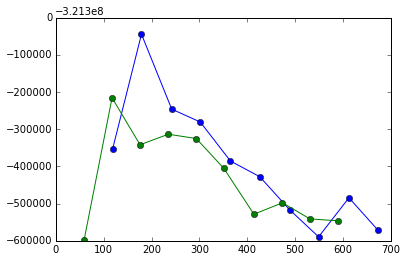

In [49]:
all_k = [20,40,100] # embedding sizes
models = []
for k in all_k:
    model = Word2Vec(size=k, min_count=10) #your code to create a model here
    models.append(model)
    scores,times = trainMod(model,sentences)
    plt.plot(times,scores,'o-');
    model.save('model-%d'%(k))
    print 'done with',k
plt.legend(['k=%d'%(k) for k in all_k],loc='lower right');
plt.xlabel('time')
plt.ylabel('log likelihood')

**Deliverable 6d** Use the ```most_similar``` function to find similar words to the items in your word_list which are in the vocabulary for your word2vec models. Compare these most similar words with the outputs of the methods tried earlier in the assignment. You may train the word2vec models for longer if you wish, or change any of the parameters. (2 points)

In [129]:
# your code here
model = Word2Vec(size=10, min_count=10, iter=20)
model.build_vocab(sentences)
model.train(sentences)

for word in word_list:
    if model.vocab.get(word, None) is not None:
        print word, model.most_similar(word, topn=10)
        print

coffee [('including', 0.8265149593353271), ('endemic', 0.8208082914352417), ('corn', 0.8206558227539062), ('fruits', 0.815038800239563), ('mining', 0.7832599878311157), ('herbaceous', 0.7749211192131042), ('affiliation', 0.7734283804893494), ('vegetables', 0.7648007869720459), ('minorities', 0.7501692771911621), ('genera', 0.7495756149291992)]

play [('Gershwin', 0.9440773129463196), ('manuscript', 0.9060929417610168), ('revised', 0.8952364325523376), ('Ward', 0.8879287838935852), ('seminal', 0.8859313130378723), ('traveler', 0.8811007738113403), ('Bates', 0.880907416343689), ('publishing', 0.871012806892395), ('instrumental', 0.864136815071106), ('publication', 0.8640176057815552)]

eat [('appear', 0.8824892044067383), ('prey', 0.870610237121582), ('counted', 0.8687939047813416), ('differentiated', 0.8647506237030029), ('far', 0.8596727848052979), ('belong', 0.8591430187225342), ('predators', 0.8566170334815979), ('longer', 0.8563065528869629), ('fur', 0.8503599762916565), ('dig', 0.8

In [131]:
model = Word2Vec(size=5, min_count=10, iter=20)
model.build_vocab(sentences)
model.train(sentences)

for word in word_list:
    if model.vocab.get(word, None) is not None:
        print word, model.most_similar(word, topn=10)
        print

coffee [('pine', 0.991111159324646), ('comprising', 0.9804106950759888), ('mountain', 0.9742515087127686), ('wool', 0.9692439436912537), ('sediments', 0.9602529406547546), ('latitudes', 0.951688826084137), ('subtropical', 0.9508953094482422), ('Alpine', 0.950741171836853), ('limestone', 0.9493807554244995), ('vehicle', 0.9488292932510376)]

play [('colleague', 0.9956479072570801), ('replied', 0.992526650428772), ('longtime', 0.9918588399887085), ('Orwell', 0.9910629987716675), ('Hastings', 0.9883396625518799), ('told', 0.9870568513870239), ('Donald', 0.9862906336784363), ('Ginsberg', 0.982170581817627), ('paper', 0.9816673398017883), ('stated', 0.980459988117218)]

eat [('pain', 0.9968546628952026), ('contact', 0.9915989637374878), ('apple', 0.9912633299827576), ('long', 0.9886532425880432), ('although', 0.9867517352104187), ('frame', 0.985264241695404), ('convert', 0.9847733974456787), ('shown', 0.9832981824874878), ('treat', 0.9795106649398804), ('wires', 0.9776336550712585)]

howeve

(your explanation here)

One of the claims about word2vec word embeddings is that they can solve analogy problems, like "man:woman::king:queen"

[This tutorial](http://rare-technologies.com/word2vec-tutorial/) contains example code showing how to use word vectors to try to solve analogies.

**Deliverable 6e** Using the three models trained in the previous deliverable, see if each can solve the analogies man:woman::king:queen and architect:building::painter:painting. Invent two more analogies, and see which of the three models can solve them. You can Google analogies, but you may have to search for a while to find analogies where all four elements are in the vocabulary. You can also retrain the models with a larger vocabulary if you want. (2 points)

In [2]:
# your code here
filename = 'oanc'
from nltk.tokenize import sent_tokenize
print "Opening the file..."
f = open(filename,'r')
count = 0
for line in f.readlines():
    line = line.decode('utf-8').strip()
    corpus = [ sent for sent in sent_tokenize(line) ]
f.close()

Opening the file...


In [46]:
# grep '[^[:blank:]]' < out.txt |   tr -cd "[:print:]" | tr "\t" " " | tr -s " " " "  | tr -cd '[:print:]' > oanc

import os
from nltk.tokenize import sent_tokenize

class MySentences(): 
    def __init__(self, filename):
        self.filename = filename
    
    def __iter__(self):
        f = open(filename,'r')
        for line in f.readlines():
            line = line.decode('utf-8')
            for sent in sent_tokenize(line):
                yield word_tokenize(sent)
                
class MySentences(): 
    def __init__(self, dirname):
        self.dirname = dirname
                
    def __iter__(self):
        for base, dirs, files in os.walk(self.dirname):
            for fname in files:
                if fname.endswith(".txt"):
                    for line in open(os.path.join(base, fname)):
                        yield line.split()        
                        
dirname = 'data/oanc'
sentences = MySentences(dirname)
model = Word2Vec(size=200, window=5, min_count=10, workers=6)
model.build_vocab(sentences)
model.train(sentences)

13655748

In [47]:
print model.most_similar(positive=['woman','father'],negative=['man'], topn=1) # woman:mother::man:father
print model.most_similar(positive=['brother','sister'],negative=['father'], topn=1) # boy:son::girl:daughter
print model.most_similar(positive=['France', 'Germany'],negative=['Paris'], topn=1) # Spain:Faro::France:Paris
print model.most_similar(positive=['bad', 'worse'],negative=['big'], topn=1) # bad worse big bigger

[('mother', 0.6708232164382935)]
[('aunt', 0.6285437345504761)]
[('Italy', 0.6088502407073975)]
[('anxiety', 0.4334152042865753)]


# 7. Semi-supervised learning #

Now you will use the word embeddings to try to improve your dependency parser from problem set 5.

You will do this by clustering words according to their embedding.

The code below run the clustering algorithm.

In [ ]:
from scipy.cluster.vq import kmeans2

In [55]:
model = Word2Vec(size=40, min_count=10, iter=10)
model.build_vocab(sentences)
model.train(sentences)

11041330

In [84]:
# choose a model to use here
word_vectors = model.syn0
num_clusters = 150
# run the clustering algorithm
centroids, labels = kmeans2(word_vectors,num_clusters,iter=100,minit='points')

**Deliverable 7a** Modify the code below to show the words in the same cluster as a query word. Find the words in the same cluster as "coffee", "computer", and "red" for at least one of your models, plus any other words of interest. (3 points)

In [85]:
def getWordsInSameCluster(word,model,labels):
    # you will use model.index2word to make this function
    # return a list of words in the same cluster as word
    if word in model.index2word:
        label = labels[model.index2word.index(word)]
        idx = [ i for i, lbl in enumerate(labels) if label == lbl ]
        return [ model.index2word[i] for i in idx ]
    else:
        return []

print getWordsInSameCluster('coffee', model, labels)[:10]
print getWordsInSameCluster('computer', model, labels)[:10]
print getWordsInSameCluster('red', model, labels)[:10]

['species', 'plants', 'contain', 'crops', 'algae', 'grown', 'almond', 'genera', 'almonds', 'trees']
['use', 'using', 'data', 'information', 'program', 'computer', 'design', 'sound', 'Ada', 'machine']
['air', 'surface', 'base', 'white', 'black', 'inside', 'covered', 'red', 'walls', 'color']


## Improving dependency parsing ##

Now incorporate these cluster features into your best performing parser from project 5, based on the dev data. Add a feature for each cluster/tag pair, e.g., C175/N, C189/V, etc. You will then compute the accuracy with training sets of various sizes, comparing the performance of your model with and without the cluster features.

**Deliverable 7b ** Build training sets including the first 50, 100, 200, 500, and 1000 *sentences* (not words). 
Train your tagger on each training set, using your original features, and plot the accuracy on the development set. 
Then retrain you tagger, including the new word cluster features, and plot accuracy on the development set on the same plot. 
Run for at least 10 iterations in each case.

You may want to try larger numbers of clusters to improve performance. 

You can even include the results from multiple clusterings with different numbers of clusters (50, 100, 200, 500, ...), 
using features like C43-50/N (cluster 43 of 50, with tag N), C377-500/V (cluster 377 of 500, with tag V).

You can also use clusters for the features of neighboring words.  (6 points)

In [92]:
import numpy as np
from os.path import join
import gtparsing
import gtparsing.dependency_parser as depp
import gtparsing.dependency_features as depf
import gtparsing.custom_features
import gtparsing.utilities

from score import accuracy
from gtparsing.custom_features import BakeoffFeats

class DependencyReader():
    


In [94]:
# your code here
class W2V_ClusterFeats(BakeoffFeats):
    def __init__():
        pass
    
    def create_arc_features(self,instance,h,m,add=False):
        ff = super(W2V_ClusterFeats, self).create_arc_features(instance,h,m,add)
        k = len(ff)
        return ff
        

In [96]:
print 'Train 100'
dp = depp.DependencyParser(feature_function=BakeoffFeats())
dp.read_data("english",100)
tr_acc ,dv_acc  = dp.train_perceptron(10) 

print 'Train 100'
dp = depp.DependencyParser(feature_function=W2V_ClusterFeats())
dp.read_data("english",100)
tr_acc ,dv_acc  = dp.train_perceptron(10) 

Train 100


TypeError: read_data() takes exactly 2 arguments (3 given)

## 8. Get creative ##

This part is mandatory for 7650 and optional for 4650.

**Deliverable 8 ** K-means clustering is one way to find similarity. This part is opened-ended and requires you to come up with creative solutions of using distributed vectors to improve the results. In addition to implementing your idea, provide explanation of what you did, and why you thought it should work.

The top 3 selected ideas (based mostly on performance, but also on creativity) will get an extra point towards their final score.(5 points)